In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import io
import itertools
import warnings

from brokenaxes import brokenaxes


import polars as pl
pl.Config.set_tbl_rows(100);
pl.Config.set_fmt_str_lengths(50);


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Create callset to infer from

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [6]:
%%time
reads_df_list = \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]


9it [00:00, 328.80it/s]
6it [00:00, 1667.72it/s]

CPU times: user 0 ns, sys: 40.8 ms, total: 40.8 ms
Wall time: 57.4 ms


In [7]:
sperm_sample_ids_except_AD = [x for x in rahbari_sample_ids + sudmant_sample_ids if x != 'PD50523b']

In [8]:
%%time
dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(inference.generate_call_set)(
        reads_df, sperm_sample_ids_except_AD, 100, False, 3, 1
    )
    for reads_df in reads_df_list
)

callset_df = pl.concat([df for df in dfs if len(df)])

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short

CPU times: user 1.59 s, sys: 2.23 s, total: 3.82 s
Wall time: 3min 2s


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  3.0min finished


In [9]:
len(callset_df)

941152

# Confirm number of COs makes sense?

## x..y, high snps

In [11]:
print(
    "# of observed 1-switches:",
    (callset_df
        .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 1)
        .select(pl.len()).item()
    ),
)

# of observed 1-switches: 6339


In [12]:
print(
    "# of high quality expected 1-switches:",
    callset_df.select(
        (pl.col("between_high_quality_snps_cM").list.slice(
            1, 
            pl.col("between_high_quality_snps_cM").list.len() - 2,
        ).list.sum() * 1e-2).alias("prob")
    )
    ["prob"].sum()
)

# of high quality expected 1-switches: 62.82356135646074


# See summary stats

In [10]:
(callset_df
    .select(pl.col("high_quality_snps_idx_transitions").list.len().alias("n_transitions"))
    .group_by("n_transitions")
    .len()
    .sort("n_transitions")
)

n_transitions,len
u32,u32
0,2598200
1,3589
2,744


In [11]:
(callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,716
2,24
3,2
4,2


In [13]:
(callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"].plot.hist()
)

alt.Chart(...)

# Run it

In [96]:
%%time
prob_factor = 1

idf = callset_df

inference.maximum_likelihood_all_reads(
    idf["read_length"].to_numpy(),
    idf["high_quality_snp_positions"].to_numpy(),
    idf["high_quality_snps_idx_transitions"].to_numpy(),
    idf["between_high_quality_snps_bp"].to_numpy() * 1e-8 * prob_factor,
    numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
    idf["weight"].to_numpy(),
    q_range = (0.05, 0.5),   
    m_range = (0.8, 1),
    GC_tract_mean_range = (5, 1000),
    GC_tract_mean2_range = (100, 100000),
    prob_factor_range = (1,1),
    read_margin_in_bp = 5000,
    x0 = [0.1, 0.98, 30, 1000, 1],
)

# inference.maximum_likelihood_all_reads(
#     idf["read_length"].to_numpy(),
#     idf["high_quality_snp_positions"].to_numpy(),
#     idf["high_quality_snps_idx_transitions"].to_numpy(),
#     idf["between_high_quality_snps_cM"].to_numpy() * 1e-2 * prob_factor,
#     idf["before_read_cM"].to_numpy() * 1e-2 * prob_factor,
#     idf["after_read_cM"].to_numpy() * 1e-2 * prob_factor,
#     idf["weight"].to_numpy(),
#     q_range = (0.05, 0.5),   
#     m_range = (0.8, 1),
#     GC_tract_mean_range = (5, 1000),
#     GC_tract_mean2_range = (100, 100000),
#     prob_factor_range = (1,1),
#     read_margin_in_bp = 5000,
#     x0 = [0.1, 0.98, 30, 1000, 1],
# )


Current:	[   0.1     0.98   30.   1000.      1.  ]	

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1031: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  S += weights_list[i] * \


137271.85878556984
Current:	[   0.105    0.98    30.    1000.       1.   ]	137250.90063914284
Current:	[   0.1      0.971   30.    1000.       1.   ]	137370.9029020259
Current:	[   0.1     0.98   31.5  1000.      1.  ]	137287.1261555321
Current:	[   0.1     0.98   30.   1050.      1.  ]	137278.76205024926
Current:	[   0.1     0.98   30.   1000.      1.  ]	137271.85878556984
Current:	[   0.102    0.989   30.6   1020.       1.   ]	137193.86861570802
Current:	[   0.103    0.998   30.9   1030.       1.   ]	137164.85366250633
Current:	[   0.103    0.987   28.86  1032.       1.   ]	137197.58757876913
Current:	[  0.104   0.99   29.904 974.8     1.   ]	137178.26372555984
Current:	[   0.106    0.994   29.866 1014.72     1.   ]	137163.79636634153
Current:	[   0.109    1.      29.798 1022.08     1.   ]	137667.71044592367
Current:	[   0.109    1.      29.812 1020.608    1.   ]	137212.85732538707
Current:	[   0.105    1.      29.737 1028.851    1.   ]	137661.4236591419
Current:	[   0.105    0.987  

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 137158.59965070928
             x: [ 9.164e-02  9.949e-01  2.591e+01  7.058e+02  1.000e+00]
           nit: 198
          nfev: 341
 final_simplex: (array([[ 9.164e-02,  9.949e-01, ...,  7.058e+02,
                         1.000e+00],
                       [ 9.164e-02,  9.949e-01, ...,  7.058e+02,
                         1.000e+00],
                       ...,
                       [ 9.164e-02,  9.949e-01, ...,  7.058e+02,
                         1.000e+00],
                       [ 9.164e-02,  9.949e-01, ...,  7.058e+02,
                         1.000e+00]]), array([ 1.372e+05,  1.372e+05,  1.372e+05,  1.372e+05,
                        1.372e+05,  1.372e+05]))

# Read results from snakemake + bootstrap

In [8]:
res = pickle.load(open("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250330/inference.take_every=10.bootstrap=0.rep=0.pcl", "rb"))

In [17]:
print(f"q = {res.x[0]*100:1.2f}%")
print(f"m = {res.x[1]*100:1.2f}%")
print(f"L1 = {res.x[2]:1.2f} bp")
print(f"L2 = {res.x[3]:1.2f} bp")

q = 11.45%
m = 98.99%
L1 = 30.49 bp
L2 = 16841.02 bp


In [4]:
import glob, pickle

pcls = glob.glob("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250330/inference.take_every=10.bootstrap=1.rep=*.pcl")
reses = [pickle.load(open(pcl, "rb")) for pcl in pcls]
all_sols = np.vstack([x.x for x in reses])

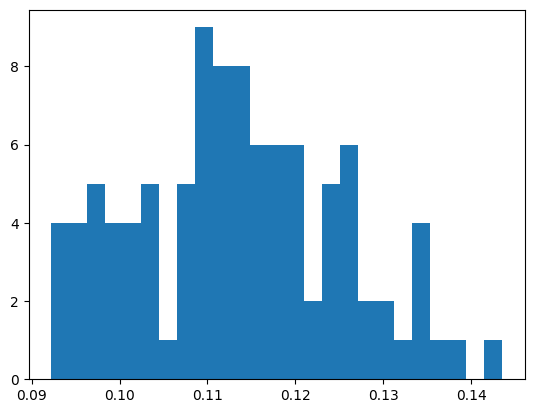

In [5]:
plt.hist(all_sols[:,0], bins=25);

In [6]:
print("CI for q:", np.quantile(all_sols[:,0], q=[0.025, 0.5, 1-0.025]))

CI for q: [0.09354339 0.11286428 0.13513177]


In [20]:
print("CI for m:", np.quantile(all_sols[:,1], q=[0.025, 0.5, 1-0.025]))

CI for m: [0.98756691 0.98983319 0.99214192]


In [21]:
print("CI for L1:", np.quantile(all_sols[:,2], q=[0.025, 0.5, 1-0.025]))

CI for L1: [23.76943173 29.92198224 38.36807126]


In [22]:
print("CI for L2:", np.quantile(all_sols[:,3], q=[0.025, 0.5, 1-0.025]))

CI for L2: [ 6242.31721158 16735.31553233 20762.98144071]


In [205]:
np.exp(((2*4 - 2*(-26726.36)) - (2*2 - 2*(-26863.94)))/2)

1.3132703631479545e-59

# Run single component

In [103]:
%%time
prob_factor = 1

idf = callset_df

# inference.maximum_likelihood_all_reads(
    # idf["read_length"].to_numpy(),
    # idf["high_quality_snp_positions"].to_numpy(),
    # idf["high_quality_snps_idx_transitions"].to_numpy(),
    # idf["between_high_quality_snps_cM"].to_numpy() * 1e-2 * prob_factor,
    # idf["before_read_cM"].to_numpy() * 1e-2 * prob_factor,
    # idf["after_read_cM"].to_numpy() * 1e-2 * prob_factor,
    # idf["weight"].to_numpy(),
    # q_range = (0.05, 0.5),   
    # m_range = (1, 1),
    # GC_tract_mean_range = (5, 1000),
    # GC_tract_mean2_range = (100, 100),
    # prob_factor_range = (1,1),
    # read_margin_in_bp = 5000,
    # x0 = [0.1, 0.98, 30, 1000, 1],
# )

inference.maximum_likelihood_all_reads(
    idf["read_length"].to_numpy(),
    idf["high_quality_snp_positions"].to_numpy(),
    idf["high_quality_snps_idx_transitions"].to_numpy(),
    idf["between_high_quality_snps_bp"].to_numpy() * 1e-8 * prob_factor,
    numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
    idf["weight"].to_numpy(),
    q_range = (0.05, 0.5),   
    m_range = (1, 1),
    GC_tract_mean_range = (5, 1000),
    GC_tract_mean2_range = (100, 100),
    prob_factor_range = (1,1),
    read_margin_in_bp = 5000,
    x0 = [0.1, 0.98, 30, 1000, 1],
)


/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1173: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(


Current:	[  0.1   1.   30.  100.    1. ]	137649.84074884534
Current:	[  0.105   1.     30.    100.      1.   ]	137654.30999215526
Current:	[  0.1   1.   30.  100.    1. ]	137649.84074884534
Current:	[  0.1   1.   31.5 100.    1. ]	137621.05846319132
Current:	[  0.1   1.   30.  100.    1. ]	137649.84074884534
Current:	[  0.1   1.   30.  100.    1. ]	137649.84074884534
Current:	[  0.095   1.     30.6   100.      1.   ]	137640.69000047396
Current:	[  0.098   1.     30.84  100.      1.   ]	137633.66545326143
Current:	[  0.097   1.     31.176 100.      1.   ]	137628.76312336046
Current:	[  0.096   1.     31.646 100.      1.   ]	137623.41870785196
Current:	[  0.095   1.     32.305 100.      1.   ]	137618.94484516597
Current:	[  0.092   1.     33.457 100.      1.   ]	137619.73518747027
Current:	[  0.099   1.     32.387 100.      1.   ]	137608.2431442197
Current:	[  0.101   1.     33.28  100.      1.   ]	137593.54701526163
Current:	[  0.098   1.     33.123 100.      1.   ]	137602.29611143246
C

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 137364.2002126563
             x: [ 2.161e-01  1.000e+00  8.217e+01  1.000e+02  1.000e+00]
           nit: 81
          nfev: 150
 final_simplex: (array([[ 2.161e-01,  1.000e+00, ...,  1.000e+02,
                         1.000e+00],
                       [ 2.161e-01,  1.000e+00, ...,  1.000e+02,
                         1.000e+00],
                       ...,
                       [ 2.161e-01,  1.000e+00, ...,  1.000e+02,
                         1.000e+00],
                       [ 2.161e-01,  1.000e+00, ...,  1.000e+02,
                         1.000e+00]]), array([ 1.374e+05,  1.374e+05,  1.374e+05,  1.374e+05,
                        1.374e+05,  1.374e+05]))

# Run meoitic + mitotic components

In [12]:
%%time
idf = callset_df

inf_res = inference.maximum_likelihood_all_reads_meiotic_mitotic(
    idf["read_length"].to_numpy(),
    idf["high_quality_snp_positions"].to_numpy(),
    idf["high_quality_snps_idx_transitions"].to_numpy(),
    # idf["between_high_quality_snps_cM"].to_numpy() * 1e-2,
    # idf["before_read_cM"].to_numpy() * 1e-2,
    # idf["after_read_cM"].to_numpy() * 1e-2,
    idf["between_high_quality_snps_bp"].to_numpy() * 1e-8,
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    idf["between_high_quality_snps_bp"].to_numpy() * 1e-8,
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    idf["weight"].to_numpy(),
    q_range_meiotic = (0.05, 0.5),   
    m_range_meiotic = (0.8, 1),
    GC_tract_mean_meiotic_range = (5, 1000),
    GC_tract_mean2_meoitic_range = (100, 100000),
    prob_factor_range_mitotic = (1e-10, 1),
    read_margin_in_bp = 5000,
    x0 = [0.1, 0.98, 30, 1000, 1],
)

Current:	[   0.1     0.98   30.   1000.      1.  ]	137332.1819325376
Current:	[   0.105    0.98    30.    1000.       1.   ]	137300.22890934368
Current:	[   0.1      0.971   30.    1000.       1.   ]	137456.90357940277
Current:	[   0.1     0.98   31.5  1000.      1.  ]	137357.4330336757
Current:	[   0.1     0.98   30.   1050.      1.  ]	137340.28649716213
Current:	[   0.1     0.98   30.   1000.      0.95]	137328.6068307545
Current:	[   0.102    0.989   30.6   1020.       0.98 ]	137228.28832281992
Current:	[   0.103    0.998   30.9   1030.       0.97 ]	137175.28283702087
Current:	[   0.103    0.987   28.86  1032.       0.968]	137222.74205413263
Current:	[  0.104   0.99   29.904 974.8     0.955]	137198.7240627588
Current:	[   0.106    0.994   29.866 1014.72     0.937]	137170.1453517318
Current:	[   0.109    1.      29.798 1022.08     0.906]	137653.13644046916
Current:	[   0.109    1.      29.812 1020.608    0.982]	137200.05461028594
Current:	[   0.105    1.      29.737 1028.851    0.925]

In [38]:
inf_res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 121411.59962536352
             x: [ 1.630e-01  8.883e-01  8.977e+01  1.000e+05  1.781e-06]
           nit: 925
          nfev: 1446
 final_simplex: (array([[ 1.630e-01,  8.883e-01, ...,  1.000e+05,
                         1.781e-06],
                       [ 1.630e-01,  8.883e-01, ...,  1.000e+05,
                         1.814e-06],
                       ...,
                       [ 1.630e-01,  8.883e-01, ...,  1.000e+05,
                         1.773e-06],
                       [ 1.630e-01,  8.883e-01, ...,  1.000e+05,
                         1.835e-06]]), array([ 1.214e+05,  1.214e+05,  1.214e+05,  1.214e+05,
                        1.214e+05,  1.214e+05]))

# Test likelihood

# Test on simulations

In [54]:
%%time
idf = callset_df

res = inference.simulate_read_patterns_probs(
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    q = 0.114,
    m = 0.99,
    GC_tract_mean = 30.5,
    GC_tract_mean2 = 16842,
    read_margin_in_bp = 5000,
)

# res = inference.simulate_read_patterns_probs(
#     numba.typed.List(idf["read_length"].to_numpy()),
#     numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
#     numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
#     numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
#     numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
#     q = 0.128,
#     m = 0.97,
#     GC_tract_mean = 29.59,
#     GC_tract_mean2 = 652,
#     read_margin_in_bp = 5000,
# )


sim_idx_transitions = [np.array([], dtype=np.int64) for i in range(len(idf))]
for i, lst in zip(res[1], res[0]):
    sim_idx_transitions[i] = np.array(lst, dtype=np.int64)
#sim_idx_transitions = np.array(sim_idx_transitions, dtype=object)
sim_callset_df = (idf
    .with_columns(high_quality_snps_idx_transitions = pl.Series(sim_idx_transitions, dtype=pl.List(pl.Int64)))
)

n_detected_COs = np.sum([1 for x in sim_idx_transitions if len(x) == 1])
n_detected_NCOs = np.sum([1 for x in sim_idx_transitions if len(x) == 2])

n_detected_NCOs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 2])
n_detected_COs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 1])

print("# events:", len(res[0]))
print("# CO events:", res[3])
print("# detected CO events:", n_detected_COs)

print("# NCO events:", res[4])
print("# detected NCO events:", n_detected_NCOs)
print("# detected NCO events from NCOs:", n_detected_NCOs_from_NCOs)
print("# detected CO events from NCOs:", n_detected_COs_from_NCOs)

print("# NCO first comp:", res[5])


Working on 21444 events
# events: 21444
# CO events: 2446
# detected CO events: 1079
# NCO events: 18998
# detected NCO events: 178
# detected NCO events from NCOs: 178
# detected CO events from NCOs: 139
# NCO first comp: 18823
CPU times: user 1min 47s, sys: 7.12 s, total: 1min 54s
Wall time: 1min 55s


In [11]:
print("Frac NCO detected:", n_detected_NCOs/res[4])

Frac NCO detected: 0.010772858827312682


In [95]:
2446/21444

0.1140645401977243

In [26]:
shorts = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1])

longs = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0])

shorts_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1]).mean()

long_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).mean()

shorts_n_snps_detected = np.array([len(idx_trans) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1])

long_n_snps_detected = np.array([len(idx_trans) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0])



In [94]:
longs.sum() / shorts.sum()

np.float64(4.884552618658227)

In [93]:
16842 * 175

2947350

In [82]:
np.array([len(idx_trans)==1 \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).sum()

np.int64(80)

In [83]:
80/175

0.45714285714285713

In [59]:
[(read_index, idx_trans, tract_length, first_switch, second_switch)
     for idx_trans, read_index, event_type, tract_type, tract_length, first_switch, second_switch in zip(res[0], res[1], res[6], res[7], res[8], res[9], res[10]) \
     if event_type == 0 and tract_type == 0][:10]


[(np.int64(5839), [], np.int64(7217), np.int64(11999), np.int64(19216)),
 (np.int64(14564), [], np.int64(727), np.int64(17667), np.int64(18394)),
 (np.int64(73669), [], np.int64(26395), np.int64(20721), np.int64(47116)),
 (np.int64(440449), [6], np.int64(7840), np.int64(7080), np.int64(14920)),
 (np.int64(675052), [], np.int64(30492), np.int64(-1811), np.int64(28681)),
 (np.int64(749334), [], np.int64(15928), np.int64(10921), np.int64(26849)),
 (np.int64(767799), [], np.int64(4331), np.int64(-1556), np.int64(2775)),
 (np.int64(931790), [1], np.int64(3727), np.int64(3848), np.int64(7575)),
 (np.int64(1026560), [], np.int64(40639), np.int64(2071), np.int64(42710)),
 (np.int64(1045130), [], np.int64(19249), np.int64(-4122), np.int64(15127))]

In [70]:
idx = 675052

display(idf["read_length"][idx])
display(idf["high_quality_snp_positions"][idx])

15490

""
i64
3005
5449
9891
10951
11201
11909
12357
13245
13320


In [85]:
long_n_snps_detected.sum(), shorts_n_snps_detected.sum()

(np.int64(87), np.int64(430))

In [86]:
430+87

517

In [84]:
print(
    "Fraction of converted SNPs coming from longs:",
    long_n_snps_detected.sum() / (long_n_snps_detected.sum() + shorts_n_snps_detected.sum())
)

Fraction of converted SNPs coming from longs: 0.16827852998065765


In [40]:
print(
    "Fraction of detected NCOs coming from longs:",
    len(np.nonzero(long_n_snps_detected)[0]) / (len(np.nonzero(long_n_snps_detected)[0]) + len(np.nonzero(shorts_n_snps_detected)[0]))
)

Fraction of detected NCOs coming from longs: 0.23417721518987342


In [19]:
shorts.mean()

np.float64(30.62228231476474)

In [21]:
longs.mean()

np.float64(16462.279761904763)

In [14]:
shorts_frac_detected

np.float64(0.010966672016262773)

In [25]:
long_frac_detected * 6/16

np.float64(0.17261904761904762)

In [22]:
len(longs)

189

In [ ]:
# Pr(NCO is long | detected NCO as NCO) = Pr(detected NCO as NCO | NCO is long) * Pr(NCO is long) / Pr(detected NCO as NCO)

# Pr(detected NCO as NCO | NCO is short) = 0.011

# Pr(detected NCO | NCO is long) = 0.46

# Pr(NCO is short) = 0.99

# Pr(NCO is long) = 0.01

# Pr(detected NCO as NCO) = 0.99 * 0.011 + 0.01 * 0.46 = 0.015

# Pr(NCO is long | detected NCO) = 0.01 * 0.46 / 0.015 = 0.31

In [23]:
0.99 * 0.011 + 0.01 * 0.46 

0.015489999999999999

In [27]:
factor = 20/16
print(0.01 * factor * 0.46 / (0.99 * 0.011 + 0.01 * factor * 0.46))

0.3455528846153847


In [16]:
print("# of NCO detected (all)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0]))
print("# of NCO detected (short)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0 and res[7][n_event] == 1]))
print("# of NCO detected (long)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0 and res[7][n_event] != 1]))

# of NCO detected (all) 175
# of NCO detected (short) 161
# of NCO detected (long) 14


In [18]:
14/175

0.08

In [31]:
print(
    "# expected CO events:", 
    (callset_df
        .select((
            (pl.col("between_high_quality_snps_cM").list.sum() + 
             pl.col("before_read_cM") + 
             pl.col("after_read_cM")
            ) * 1e-2).alias("prob")
        )
    )["prob"].sum()
)
        

# expected CO events: 522.5405433017486


In [11]:
print(
    "# of high quality expected 1-switches:",
    callset_df.select(
        (pl.col("between_high_quality_snps_cM").list.slice(
            1, 
            pl.col("between_high_quality_snps_cM").list.len() - 2,
        ).list.sum() * 1e-2).alias("prob")
    )
    ["prob"].sum()
)

# of high quality expected 1-switches: 181.4897911193739


In [89]:
(sim_callset_df
    .select(pl.col("high_quality_snps_idx_transitions").list.len().alias("n_transitions"))
    .group_by("n_transitions")
    .len()
    .sort("n_transitions")
)

n_transitions,len
u32,u32
0,9837574
1,935
2,244


In [91]:
(sim_callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,208
2,21
3,8
4,2
5,1
7,1
9,3


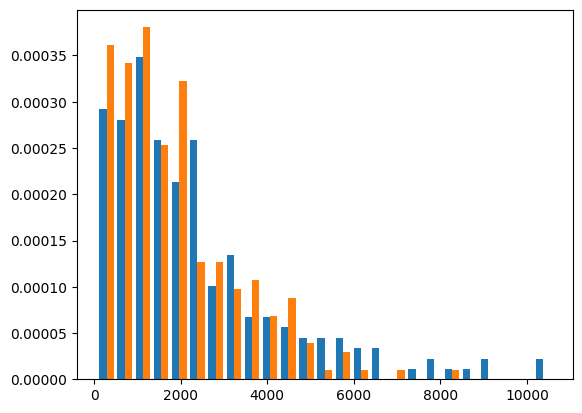

In [92]:
plt.hist(
    [
        (callset_df
            .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
            .select(
                (
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
                ).alias("upper_bound")            
            )
            ["upper_bound"]
        ),
        (sim_callset_df
            .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
            .select(
                (
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
                ).alias("upper_bound")            
            )
            ["upper_bound"]
        ),
    ],
    bins=25,
    density=True,
);

# What is the full distribution from reads

## Run on many reads

### High quality reads

In [104]:
%%time
idf = callset_df

D_mix, C_mix = inference.tract_length_upper_bound_dist_from_many_reads(
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    numba.typed.List(idf["weight"].to_numpy()),
    q = 0.092,
    m = 0.995,
    GC_tract_mean = 25.9,
    GC_tract_mean2 = 705.7,
    read_margin_in_bp = 5000,
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    # numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    # numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    # numba.typed.List(idf["weight"].to_numpy()),
    # q = 0.114,
    # m = 0.99,
    # GC_tract_mean = 30.5,
    # GC_tract_mean2 = 16842,
    # read_margin_in_bp = 5000,
)

D_one, C_one = inference.tract_length_upper_bound_dist_from_many_reads(
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    numba.typed.List(idf["weight"].to_numpy()),
    q = 0.216,
    m = 1,
    GC_tract_mean = 82.2,
    GC_tract_mean2 = 100,
    read_margin_in_bp = 5000,    
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    # numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    # numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    # numba.typed.List(idf["weight"].to_numpy()),    
    # q = 0.238,
    # m = 1,
    # GC_tract_mean = 85,
    # GC_tract_mean2 = 1000,
    # read_margin_in_bp = 5000,
)



CPU times: user 54min 11s, sys: 20.1 s, total: 54min 31s
Wall time: 7min 10s


### Plot and compare

In [98]:
upper_bound = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"]
)

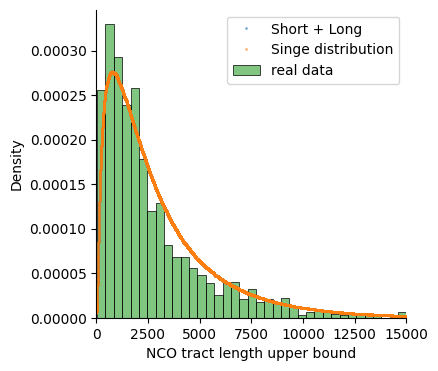

In [99]:
import scipy.ndimage


smooth = 100

fig, ax = plt.subplots(figsize=(4,4))

ax.plot(
    scipy.ndimage.uniform_filter1d(D_mix, smooth), 
    '.', ms=2, alpha=0.5, 
    label="Short + Long",
    color="C0",
);
ax.plot(
    scipy.ndimage.uniform_filter1d(D_one, smooth), 
    '.', ms=2, 
    alpha=0.5, 
    label="Singe distribution",
    color="C1",
);
#plt.ylim(0, 0.00005);
ax.set_xlim(0, 15000);


sns.histplot(
    upper_bound,
    ax=ax,
    #kde=True,
    stat="density",
    color="C2",
    bins=50,
    label="real data",
    alpha=0.6,
    linewidth=0.5,
)
# plt.hist(
#     upper_bound,
#     bins=200,
#     density=True,
#     label="real",
# );

plt.legend();

sns.despine(ax=ax)
ax.set_xlabel("NCO tract length upper bound");

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_tract_length.pdf")

In [100]:
conv_df = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

In [101]:
import statsmodels.stats.proportion

R = np.zeros(10)
for n, c in conv_df.rows():
    R[n] = c

mns = R / R.sum()
cis = [statsmodels.stats.proportion.proportion_confint(c, R.sum()) for c in R]

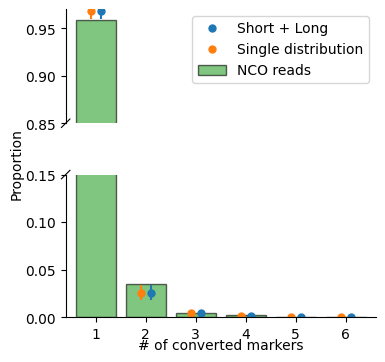

In [102]:
fig = plt.figure(figsize=(4,4))

bax = brokenaxes(xlims=[(0.4, 6.6)], ylims=[(0, 0.15), (0.85, 0.97)], hspace=.4)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_df["len"].sum(), C_mix) / conv_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_df["len"].sum(), C_mix) / conv_df["len"].sum()

bax.plot(
    np.arange(len(mns))+0.1,
    C_mix, 
    '.', 
    color="C0",
    label="Short + Long",
    ms=10,    
)
bax.errorbar(
    x = np.arange(len(mns))+0.1,
    y = C_mix,
    yerr = np.maximum(0, np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_mix, ci_low_mix, ci_high_mix)]).T),
    ls = ' ',
    color='C0',
)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_df["len"].sum(), C_one) / conv_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_df["len"].sum(), C_one) / conv_df["len"].sum()
bax.plot(
    np.arange(len(mns))-0.1,
    C_one, 
    '.', 
    color="C1",
    label="Single distribution",
    ms=10,
)
bax.errorbar(
    x = np.arange(len(mns))-0.1,
    y = C_one,
    yerr = np.maximum(0, np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_one, ci_low_mix, ci_high_mix)]).T),
    ls = ' ',
    color='C1',
)


bax.bar(
    x=np.arange(len(mns)),
    height=mns, 
    color=NCO_color,
    alpha=0.6,
    label="NCO reads",
    edgecolor="black",
    linewidth=1,
)

bax.set_xlabel("# of converted markers")
bax.set_ylabel("Proportion");
bax.legend();

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_converted.pdf")